First we will import packages


In [129]:


import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import torch
import torch.nn as nn
from IPython import display
import random
from NeuralNetUtils import RawData, NeuralNetwork, DataSet
import NeuralNetUtils as nnu
%matplotlib inline


Setup the environment. We will train a model to play the Lunar-Lander-V2 environment from the gym library.

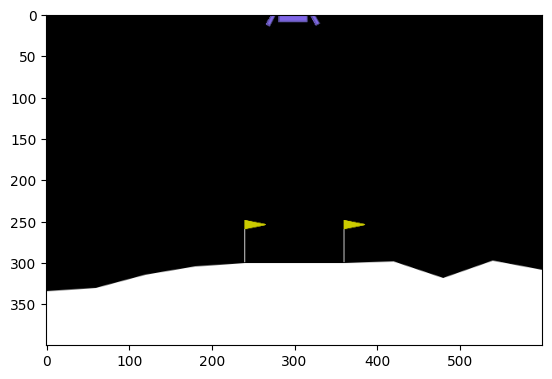

In [130]:
GAME_NAME = 'LunarLander-v3'
env = gym.make(GAME_NAME, render_mode='rgb_array')
state = env.reset()
fig, ax = plt.subplots()

def RenderFrame(env,envState=None):
    ax.clear()  # Clear the previous image
    arr = env.render()
    ax.imshow(arr)
    def DisplayData():
        if envState is None: return
        ax.text(1,1,F"(X, Y): ({envState.x}, {envState.y})")
    DisplayData()
    display.display(fig)  # Display the figure object
    display.clear_output(wait=True)  # Clear the output for the next frame
    






RenderFrame(env)



Let's get an insight into our environment

In [131]:
def PrintEnvironmentSpecs(environmentName: str):
    env = gym.make(environmentName)
    spec = gym.spec(environmentName)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Threshold: {spec.reward_threshold}")

PrintEnvironmentSpecs(GAME_NAME)

Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Threshold: 200


Using this info, lets create a data object to store environment data in a more human-readable format

In [132]:
class EnvironmentState:
    def __init__(self,state):
        coord = state[0]
        self.x = coord[0]
        self.y = coord[1]
        self.x_dot = coord[2]
        self.y_dot = coord[3]
        self.theta = coord[4]
        self.theta_dot = coord[5]
        self.leftLegTouching = int(coord[6])
        self.rightLegTouching = int(coord[7])
        reward = 0
        isDone = False
        if len(state)>2:
            reward = state[1]
            isDone = state[2] or state[3]
        self.reward = reward
        self.isDone = isDone 
    
    def __repr__(self):
        lines = [
            f"(x, y): ({self.x}, {self.y})",
            f"(ẋ, ẏ): ({self.x_dot}, {self.y_dot})",
            f"θ: {self.theta}",
            f"dθ/dt: {self.theta_dot}",
            f"Legs touching (L,R): ({self.leftLegTouching}, {self.rightLegTouching})",
            f" Reward: {self.reward}",
            f" Done: {self.isDone}",
        ]
        return "\n".join(lines,)

    def toTensor(self) -> torch.Tensor:
        return torch.tensor(self.toList())
    
    def toArray(self) -> np.array:
        return np.array(self.toList())
    
    def toList(self) -> List[float]:
        return [self.x, self.y, self.x_dot, self.y_dot, self.theta, self.theta_dot, self.leftLegTouching, self.rightLegTouching]

Lets take a look at the model's observation

In [133]:
print(state)
print(len(state))
envState = EnvironmentState(state)

print(envState)

(array([-0.00481272,  1.4124126 , -0.48749337,  0.06632425,  0.00558352,
        0.11042438,  0.        ,  0.        ], dtype=float32), {})
2
(x, y): (-0.004812717437744141, 1.4124126434326172)
(ẋ, ẏ): (-0.4874933660030365, 0.06632424890995026)
θ: 0.00558351818472147
dθ/dt: 0.11042437702417374
Legs touching (L,R): (0, 0)
 Reward: 0
 Done: False


And lets run a quick iteration of the game, watching the state to make sure everything is working well

In [134]:
playAnimation = False
if playAnimation:#Change to true/false to play/skip animation
    envState = EnvironmentState(env.reset())
    while not envState.isDone:
        envState = EnvironmentState(env.step(0))
        RenderFrame(env,envState)


Now we'll make a class for the model

In [135]:
  

class Model:

    def __init__(self, epsilon : float, gamma : float, network : NeuralNetwork):
        self.epsilon = epsilon
        self.network = network
        self.gamma = gamma
    
    def CalculateAllQ(self, state: EnvironmentState) -> List[float]: #returns estimated Q for each action possibility
        tensor = self.network.forward(state.toTensor())
        return nnu.convertToNumpy(tensor)
    
    def GetDecision(self, state: EnvironmentState) -> List[float]: #returns a list of all zeros except for a single 1 for the chosen decision
        allQ = self.CalculateAllQ(state)
        idx = np.argmax(allQ)

        rand = random.uniform(0,1)
        if rand < self.epsilon:
            idx = random.randint(0, len(allQ) - 1)

        action = np.zeros(len(allQ))
        action[idx] = 1
        return action.astype(np.float32)
    
    def convertData(self, data : List[RawData[EnvironmentState]]) -> DataSet:
        rowCount = len(data)
        firstRow = data[0].State
        firstRowPredictions = self.CalculateAllQ(firstRow)
        X = np.zeros((rowCount,len(firstRow.toList())))
        Y = np.zeros((rowCount,len(firstRowPredictions)))

        for (i,row) in  enumerate(data):
            x = row.State.toArray()
            qPrime = self.CalculateAllQ(row.NextState)
            q = self.gamma * qPrime + row.Reward
            X[i] = x
            Y[i] = q
        return DataSet.buildFromNumpy(X,Y)
    
    def Train(self, data : List[RawData], loss, trainingParams):
        dataSet = self.convertData(data)
        nnu.trainModel([dataSet],self.network,loss, trainingParams)
        


Now lets define a reward function based on the environment state

In [136]:
def Reward(state:EnvironmentState) -> float:
    return state.reward#for now just return the built-in reward function

Lets define the training function

In [137]:

def GetTrainingDataBatch(model : Model, batchSize : int):
    data : List[RawData] = []
    state : EnvironmentState = None
    for i in range(batchSize):
        if state is None or state.isDone:
            state = EnvironmentState(env.reset())
        reward = Reward(state)
        action = model.GetDecision(state)
        nextState = EnvironmentState(env.step(np.argmax(action)))
        dataPoint: RawData = RawData(state,action,reward,nextState)
        data.append(dataPoint)
        state = nextState
    return data
    



And train the model!

In [138]:
BATCH_SIZE = 1000

hiddenLayers = [100,50,2]
layers = nnu.buildLayers(hiddenLayers)
inputFeatureCount = len(envState.toTensor())
network = NeuralNetwork(inputFeatureCount,layers)
model = Model(.05,.99,network)
trainingParams = nnu.TrainingParams() 
trainingParams.learningRate = 1e-2
trainingParams.regularizationConstant = 1e-2
trainingParams.iterations = 600
loss = nn.BCELoss()

EPISODES = 100
for i in range (EPISODES):
    data = GetTrainingDataBatch(model, BATCH_SIZE)
    model.Train(data,loss, trainingParams)




TypeError: DataSet.__init__() takes 3 positional arguments but 4 were given